In [63]:
import os
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
from src.tools import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Analysis

In the following I will be exploring the Home Insurance dataset for 2007-2012 (found here: https://www.kaggle.com/datasets/ycanario/home-insurance?resource=download).  

## Motivation
The dataset contains home insurance policy data, including active and inactive (lapsed or cancelled). In the following I will derive some insights into the data, and I will also investigate whether the various features can be used to predict if a policy is active or inactive.

## Outline (roughly)
- Data ingestion
- Data inspection
    - Some insights
- Data transformations and cleansing
- Modeling
- Results
- Discussion

## Data Ingestions

In [64]:
# Env
datadir = './data'
datafile = 'home_insurance.csv'

datapath = os.path.join(datadir, datafile)

In [65]:
# Load data
with open(datapath) as f:
    hi_df = pd.read_csv(f)
    
hi_df

,QUOTE_DATE,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,P1_PT_EMP_STATUS,BUS_USE,CLERICAL,AD_BUILDINGS,RISK_RATED_AREA_B,SUM_INSURED_BUILDINGS,...,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,MTA_FAP,MTA_APRP,MTA_DATE,LAST_ANN_PREM_GROSS,POL_STATUS,i,Police
0,11/22/2007,22/11/2007,N,R,NaN,N,NaN,Y,19.0,1000000.0,...,N,N,N,NaN,NaN,NaN,274.81,Lapsed,1,P000001
1,11/22/2007,01/01/2008,N,E,NaN,Y,N,Y,25.0,1000000.0,...,N,N,Y,308.83,-9.27,NaN,308.83,Live,2,P000002
2,11/23/2007,23/11/2007,N,E,NaN,N,NaN,N,NaN,0.0,...,N,N,Y,52.65,52.65,03/11/2010,52.65,Live,3,P000003
3,11/23/2007,12/12/2007,N,R,NaN,N,NaN,N,NaN,0.0,...,N,N,N,NaN,NaN,NaN,54.23,Live,4,P000004
4,11/22/2007,15/12/2007,N,R,NaN,N,NaN,Y,5.0,1000000.0,...,N,N,N,NaN,NaN,NaN,244.58,Live,5,P000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256131,NaN,22/02/2005,Y,R,NaN,N,NaN,Y,16.0,1000000.0,...,N,N,N,NaN,NaN,NaN,235.08,Lapsed,256132,P256132
256132,NaN,01/12/2000,N,R,NaN,N,NaN,Y,0.0,1000000.0,...,N,N,Y,194.02,194.02,01/12/2010,194.02,Live,256133,P256133
256133,NaN,18/01/2006,N,R,NaN,N,NaN,Y,1.0,1000000.0,...,N,N,N,NaN,NaN,NaN,287.30,Live,256134,P256134
256134,NaN,31/12/2004,N,R,NaN,N,NaN,Y,32.0,1000000.0,...,N,N,N,NaN,NaN,NaN,457.57,Lapsed,256135,P256135


## Data transformations and cleansing

In [66]:
for col in hi_df.columns:
    print(f'Number of NaN values in column {col} : ', hi_df[col].isna().sum())
# hi_df.isna().sum()

Number of NaN values in column QUOTE_DATE :  126612
Number of NaN values in column COVER_START :  67115
Number of NaN values in column CLAIM3YEARS :  66097
Number of NaN values in column P1_EMP_STATUS :  67115
Number of NaN values in column P1_PT_EMP_STATUS :  254354
Number of NaN values in column BUS_USE :  67115
Number of NaN values in column CLERICAL :  253192
Number of NaN values in column AD_BUILDINGS :  67115
Number of NaN values in column RISK_RATED_AREA_B :  115260
Number of NaN values in column SUM_INSURED_BUILDINGS :  67115
Number of NaN values in column NCD_GRANTED_YEARS_B :  67115
Number of NaN values in column AD_CONTENTS :  67115
Number of NaN values in column RISK_RATED_AREA_C :  75846
Number of NaN values in column SUM_INSURED_CONTENTS :  67115
Number of NaN values in column NCD_GRANTED_YEARS_C :  67115
Number of NaN values in column CONTENTS_COVER :  67115
Number of NaN values in column BUILDINGS_COVER :  67115
Number of NaN values in column SPEC_SUM_INSURED :  67115
N

In [67]:
hi_df.POL_STATUS.value_counts()

POL_STATUS
Live         132160
Lapsed        52534
Cancelled      4311
Unknown          16
Name: count, dtype: int64

## Data Inspection

### Initial Observations


- The dataset is full of incomplete data entries. Of a total 256136 rows 
    - at least 66097 are not populated (excpet for index and policy ID column entries)
    - the vast majority of columns lack data for 67115 rows
- Policy status (`POL_STATUS`) fall into four categories: Live, Lapsed, Cancelled, Unknown. There are only 16 rows of 'Unknown' policy status
- Three columns contain datetime data
- There is seemingly *no* column with credit history
- There is no indication of when a policy was cancelled, lapsed. We only know its status as it was by end of 2012

### Further Insights
- Once the 67115 aforementioned rows + the ones with policy status 'Unknown' have been removed, we are left with 189005 fully populated rows
- I have decided to treat 'Cancelled' and 'Lapsed' policies on the same footing (and label them 'inactive') we are left with 132160 'active' policies, and 56845 'inactive' policies
    - We thus have an **imbalanced** dataset
  
  

In the following we extract a bit more information, step-wise.

### Remove rows and columns with incomplete data

- I remove columns that have more than 67115 incomplete rows
- I remove rows with 'Unknown' policy status

In [68]:
non_blacklist_cols = list()
blacklist_limit = 67115

# Drop columns with more than 67115 NaN values
for col in hi_df.columns:
    if hi_df[col].isna().sum() <= blacklist_limit:
        non_blacklist_cols.append(col)
    else:
        print(f"Column labelled '{col}' to be dropped")

non_blacklist_cols
print("Cols. to be kept for now : ", non_blacklist_cols)

# Drop 'i' and 'Police', they are just IDs
hi_df_filter_1 = hi_df[non_blacklist_cols].drop(['i', 'Police'], axis=1)
hi_df_filter_1

hi_df_filter_2 = hi_df_filter_1[hi_df_filter_1.COVER_START.notna()]

# Place 'Lapsed' and 'Cancelled' in same category
pol_status_dict = {'Lapsed': 'inactive', 'Cancelled': 'inactive', 'Live': 'active'}
hi_df_filter_2['POL_STATUS'] = hi_df_filter_2['POL_STATUS'].replace(pol_status_dict) 

# Remove 'Unknown' for now
hi_df_filter_3 = hi_df_filter_2[~hi_df_filter_2.POL_STATUS.isin(['Unknown'])]
hi_df_filter_3
hi_df_filter_3.isna().sum()

len(hi_df_filter_3.loc[hi_df_filter_3.POL_STATUS == 'active']), len(hi_df_filter_3.loc[hi_df_filter_3.POL_STATUS == 'inactive'])
hi_df_filter_3

Column labelled 'QUOTE_DATE' to be dropped
Column labelled 'P1_PT_EMP_STATUS' to be dropped
Column labelled 'CLERICAL' to be dropped
Column labelled 'RISK_RATED_AREA_B' to be dropped
Column labelled 'RISK_RATED_AREA_C' to be dropped
Column labelled 'CAMPAIGN_DESC' to be dropped
Column labelled 'PAYMENT_FREQUENCY' to be dropped
Column labelled 'MTA_FAP' to be dropped
Column labelled 'MTA_APRP' to be dropped
Column labelled 'MTA_DATE' to be dropped
Cols. to be kept for now :  ['COVER_START', 'CLAIM3YEARS', 'P1_EMP_STATUS', 'BUS_USE', 'AD_BUILDINGS', 'SUM_INSURED_BUILDINGS', 'NCD_GRANTED_YEARS_B', 'AD_CONTENTS', 'SUM_INSURED_CONTENTS', 'NCD_GRANTED_YEARS_C', 'CONTENTS_COVER', 'BUILDINGS_COVER', 'SPEC_SUM_INSURED', 'SPEC_ITEM_PREM', 'UNSPEC_HRP_PREM', 'P1_DOB', 'P1_MAR_STATUS', 'P1_POLICY_REFUSED', 'P1_SEX', 'APPR_ALARM', 'APPR_LOCKS', 'BEDROOMS', 'ROOF_CONSTRUCTION', 'WALL_CONSTRUCTION', 'FLOODING', 'LISTED', 'MAX_DAYS_UNOCC', 'NEIGH_WATCH', 'OCC_STATUS', 'OWNERSHIP_TYPE', 'PAYING_GUESTS'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,BUS_USE,AD_BUILDINGS,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,AD_CONTENTS,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,...,KEYCARE_ADDON_POST_REN,HP1_ADDON_PRE_REN,HP1_ADDON_POST_REN,HP2_ADDON_PRE_REN,HP2_ADDON_POST_REN,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,LAST_ANN_PREM_GROSS,POL_STATUS
0,22/11/2007,N,R,N,Y,1000000.0,7.0,Y,50000.0,7.0,...,N,N,N,N,N,N,N,N,274.81,inactive
1,01/01/2008,N,E,Y,Y,1000000.0,6.0,Y,50000.0,7.0,...,N,N,N,N,N,N,N,Y,308.83,active
2,23/11/2007,N,E,N,N,0.0,0.0,Y,50000.0,7.0,...,N,N,N,N,N,N,N,Y,52.65,active
3,12/12/2007,N,R,N,N,0.0,0.0,Y,50000.0,7.0,...,N,N,N,N,N,N,N,N,54.23,active
4,15/12/2007,N,R,N,Y,1000000.0,7.0,Y,50000.0,7.0,...,N,N,N,N,N,N,N,N,244.58,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256131,22/02/2005,Y,R,N,Y,1000000.0,2.0,Y,50000.0,2.0,...,N,N,N,N,N,N,N,N,235.08,inactive
256132,01/12/2000,N,R,N,Y,1000000.0,5.0,Y,50000.0,5.0,...,N,N,N,N,N,N,N,Y,194.02,active
256133,18/01/2006,N,R,N,Y,1000000.0,5.0,Y,50000.0,5.0,...,N,N,N,N,N,N,N,N,287.30,active
256134,31/12/2004,N,R,N,Y,1000000.0,5.0,N,0.0,0.0,...,N,N,N,N,N,N,N,N,457.57,inactive


In [69]:
hi_df_filter_3.POL_STATUS.value_counts()

POL_STATUS
active      132160
inactive     56845
Name: count, dtype: int64

### Transform dates to ages in 2012

Calculate the age (in years) at the end date (31/12/2024) for the data
1. of the policy
2. of insured customer

In [70]:
date_cols = {"COVER_START": "COVER_AGE", "P1_DOB": "P1_AGE"}

# Set end date to 31/12/2012 - last date in dataset
end_date = pd.Timestamp(2012,12, 31)

hi_df_filter_4 = dates_to_ages(hi_df_filter_3, date_cols=date_cols, end_date=end_date)
hi_df_filter_4 

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,BUS_USE,AD_BUILDINGS,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,AD_CONTENTS,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,...,HP1_ADDON_POST_REN,HP2_ADDON_PRE_REN,HP2_ADDON_POST_REN,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,LAST_ANN_PREM_GROSS,POL_STATUS,COVER_AGE,P1_AGE
0,22/11/2007,N,R,N,Y,1000000.0,7.0,Y,50000.0,7.0,...,N,N,N,N,N,N,274.81,inactive,5,73
1,01/01/2008,N,E,Y,Y,1000000.0,6.0,Y,50000.0,7.0,...,N,N,N,N,N,Y,308.83,active,5,42
2,23/11/2007,N,E,N,N,0.0,0.0,Y,50000.0,7.0,...,N,N,N,N,N,Y,52.65,active,5,65
3,12/12/2007,N,R,N,N,0.0,0.0,Y,50000.0,7.0,...,N,N,N,N,N,N,54.23,active,5,87
4,15/12/2007,N,R,N,Y,1000000.0,7.0,Y,50000.0,7.0,...,N,N,N,N,N,N,244.58,active,5,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256131,22/02/2005,Y,R,N,Y,1000000.0,2.0,Y,50000.0,2.0,...,N,N,N,N,N,N,235.08,inactive,7,75
256132,01/12/2000,N,R,N,Y,1000000.0,5.0,Y,50000.0,5.0,...,N,N,N,N,N,Y,194.02,active,12,84
256133,18/01/2006,N,R,N,Y,1000000.0,5.0,Y,50000.0,5.0,...,N,N,N,N,N,N,287.30,active,6,67
256134,31/12/2004,N,R,N,Y,1000000.0,5.0,N,0.0,0.0,...,N,N,N,N,N,N,457.57,inactive,8,75


#### Derive some basic stats from the data

In [71]:
# Avg. age of policy holder
# Live holders
pol_status = 'active'
avg_age_policy_on = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].P1_AGE.mean()
std_age_policy_on = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].P1_AGE.std()
# hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].P1_AGE.hist()
print(f"Avg. age of holder of live policy : {avg_age_policy_on} +/- {std_age_policy_on}")
print("---")
avg_ann_premium_on = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].LAST_ANN_PREM_GROSS.mean()
std_ann_premium_on = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].LAST_ANN_PREM_GROSS.std()
print(f"Avg. annual premium of holder of live policy : {avg_ann_premium_on} +/- {std_ann_premium_on}")
print("---")
threeyr_claim_on = len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status) & (hi_df_filter_4.CLAIM3YEARS == 'Y')])/ len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status)])
print(f"Fraction having claimed in the past 3 years : {threeyr_claim_on} ")
print("---")
policy_refused_on = len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status) & (hi_df_filter_4.P1_POLICY_REFUSED == 'Y')])/ len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status)])
print(f"Fraction having had policy refused : {policy_refused_on} ")

print("===========")

# Inactive holders
pol_status = 'inactive'
avg_age_policy_off = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].P1_AGE.mean()
std_age_policy_off = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].P1_AGE.std()
print(f"Avg. age of holder of inactive policy : {avg_age_policy_off} +/- {std_age_policy_off}")
print("---")
avg_ann_premium_off = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].LAST_ANN_PREM_GROSS.mean()
std_ann_premium_off = hi_df_filter_4.loc[hi_df_filter_4.POL_STATUS == pol_status].LAST_ANN_PREM_GROSS.std()
print(f"Avg. annual premium of holder of inactive policy : {avg_ann_premium_off} +/- {std_ann_premium_off}")
print("---")
threeyr_claim_off = len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status) & (hi_df_filter_4.CLAIM3YEARS == 'Y')])/ len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status)])
print(f"Fraction having claimed in the past 3 years : {threeyr_claim_off} ")
print("---")
policy_refused_off = len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status) & (hi_df_filter_4.P1_POLICY_REFUSED == 'Y')])/ len(hi_df_filter_4.loc[(hi_df_filter_4.POL_STATUS == pol_status)])
print(f"Fraction having had policy refused : {policy_refused_off} ")





Avg. age of holder of live policy : 73.16122881355932 +/- 11.026779986187393
---
Avg. annual premium of holder of live policy : 182.28639512711865 +/- 98.82352154088903
---
Fraction having claimed in the past 3 years : 0.11713831719128329 
---
Fraction having had policy refused : 0.0001740314769975787 
Avg. age of holder of inactive policy : 71.59171431084528 +/- 10.575516560168465
---
Avg. annual premium of holder of inactive policy : 197.0453827073621 +/- 100.28647573273965
---
Fraction having claimed in the past 3 years : 0.11177764095346997 
---
Fraction having had policy refused : 0.0007036678687659425 


In [72]:
hi_df_filter_4.P1_POLICY_REFUSED.value_counts()

P1_POLICY_REFUSED
N    188942
Y        63
Name: count, dtype: int64

### Convert categorical columns to numerical

- We convert columns that contain categorical data

In [73]:
# Capture the mapping between the original and encoded values
hi_df_cat = hi_df_filter_4.copy()

code_to_cat = dict()
for col in hi_df_cat.columns:
    if is_string_dtype(hi_df_cat[col]):
        # hi_df_cat[col] = hi_df_cat[col].astype('category').cat.codes
        code_to_cat[col] = dict( zip( hi_df_cat[col].astype('category').cat.codes, hi_df_cat[col] ) )
code_to_cat

{'COVER_START': {1592: '22/11/2007',
  15: '01/01/2008',
  1664: '23/11/2007',
  883: '12/12/2007',
  1104: '15/12/2007',
  74: '01/12/2007',
  34: '01/02/2008',
  522: '07/12/2007',
  1611: '22/12/2007',
  2164: '30/12/2007',
  1409: '20/01/2008',
  2203: '31/12/2007',
  1481: '21/01/2008',
  200: '03/03/2008',
  1827: '25/12/2007',
  1029: '14/12/2007',
  1120: '16/01/2008',
  1390: '19/12/2007',
  721: '10/11/2007',
  1155: '16/11/2007',
  851: '12/02/2011',
  1085: '15/11/2007',
  866: '12/11/2007',
  1518: '21/11/2007',
  2146: '30/11/2007',
  363: '05/11/2007',
  575: '08/11/2007',
  56: '01/03/2011',
  310: '05/01/2011',
  1735: '24/11/2007',
  435: '06/11/2007',
  1246: '17/12/2007',
  1229: '17/11/2007',
  1754: '24/12/2007',
  2029: '28/11/2007',
  504: '07/11/2007',
  1882: '26/11/2007',
  955: '13/12/2007',
  217: '03/12/2007',
  1899: '26/12/2007',
  740: '10/12/2007',
  1555: '22/01/2008',
  848: '12/02/2008',
  1536: '21/12/2007',
  399: '06/01/2008',
  937: '13/11/2007'

In [74]:
# Save the mapping
with open('./data/code_to_cat.json', 'w') as f:
    json.dump(code_to_cat, f)

In [75]:
# Convert categorical to numerical (int) representation

pol_status_dict_2 = {'active': 1, 'inactive': 0}

hi_df_cat['POL_STATUS'] = hi_df_cat['POL_STATUS'].replace(pol_status_dict_2)

for col in hi_df_cat.columns:
    if is_string_dtype(hi_df_cat[col]):
        hi_df_cat[col] = hi_df_cat[col].astype('category').cat.codes
    
# is_string_dtype( hi_df_filter_2.i)
hi_df_cat

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,BUS_USE,AD_BUILDINGS,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,AD_CONTENTS,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,...,HP1_ADDON_POST_REN,HP2_ADDON_PRE_REN,HP2_ADDON_POST_REN,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,LAST_ANN_PREM_GROSS,POL_STATUS,COVER_AGE,P1_AGE
0,1592,0,7,0,1,1000000.0,7.0,1,50000.0,7.0,...,0,0,0,0,0,0,274.81,0,5,73
1,15,0,2,1,1,1000000.0,6.0,1,50000.0,7.0,...,0,0,0,0,0,1,308.83,1,5,42
2,1664,0,2,0,0,0.0,0.0,1,50000.0,7.0,...,0,0,0,0,0,1,52.65,1,5,65
3,883,0,7,0,0,0.0,0.0,1,50000.0,7.0,...,0,0,0,0,0,0,54.23,1,5,87
4,1104,0,7,0,1,1000000.0,7.0,1,50000.0,7.0,...,0,0,0,0,0,0,244.58,1,5,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256131,1570,1,7,0,1,1000000.0,2.0,1,50000.0,2.0,...,0,0,0,0,0,0,235.08,0,7,75
256132,67,0,7,0,1,1000000.0,5.0,1,50000.0,5.0,...,0,0,0,0,0,1,194.02,1,12,84
256133,1262,0,7,0,1,1000000.0,5.0,1,50000.0,5.0,...,0,0,0,0,0,0,287.30,1,6,67
256134,2200,0,7,0,1,1000000.0,5.0,0,0.0,0.0,...,0,0,0,0,0,0,457.57,0,8,75


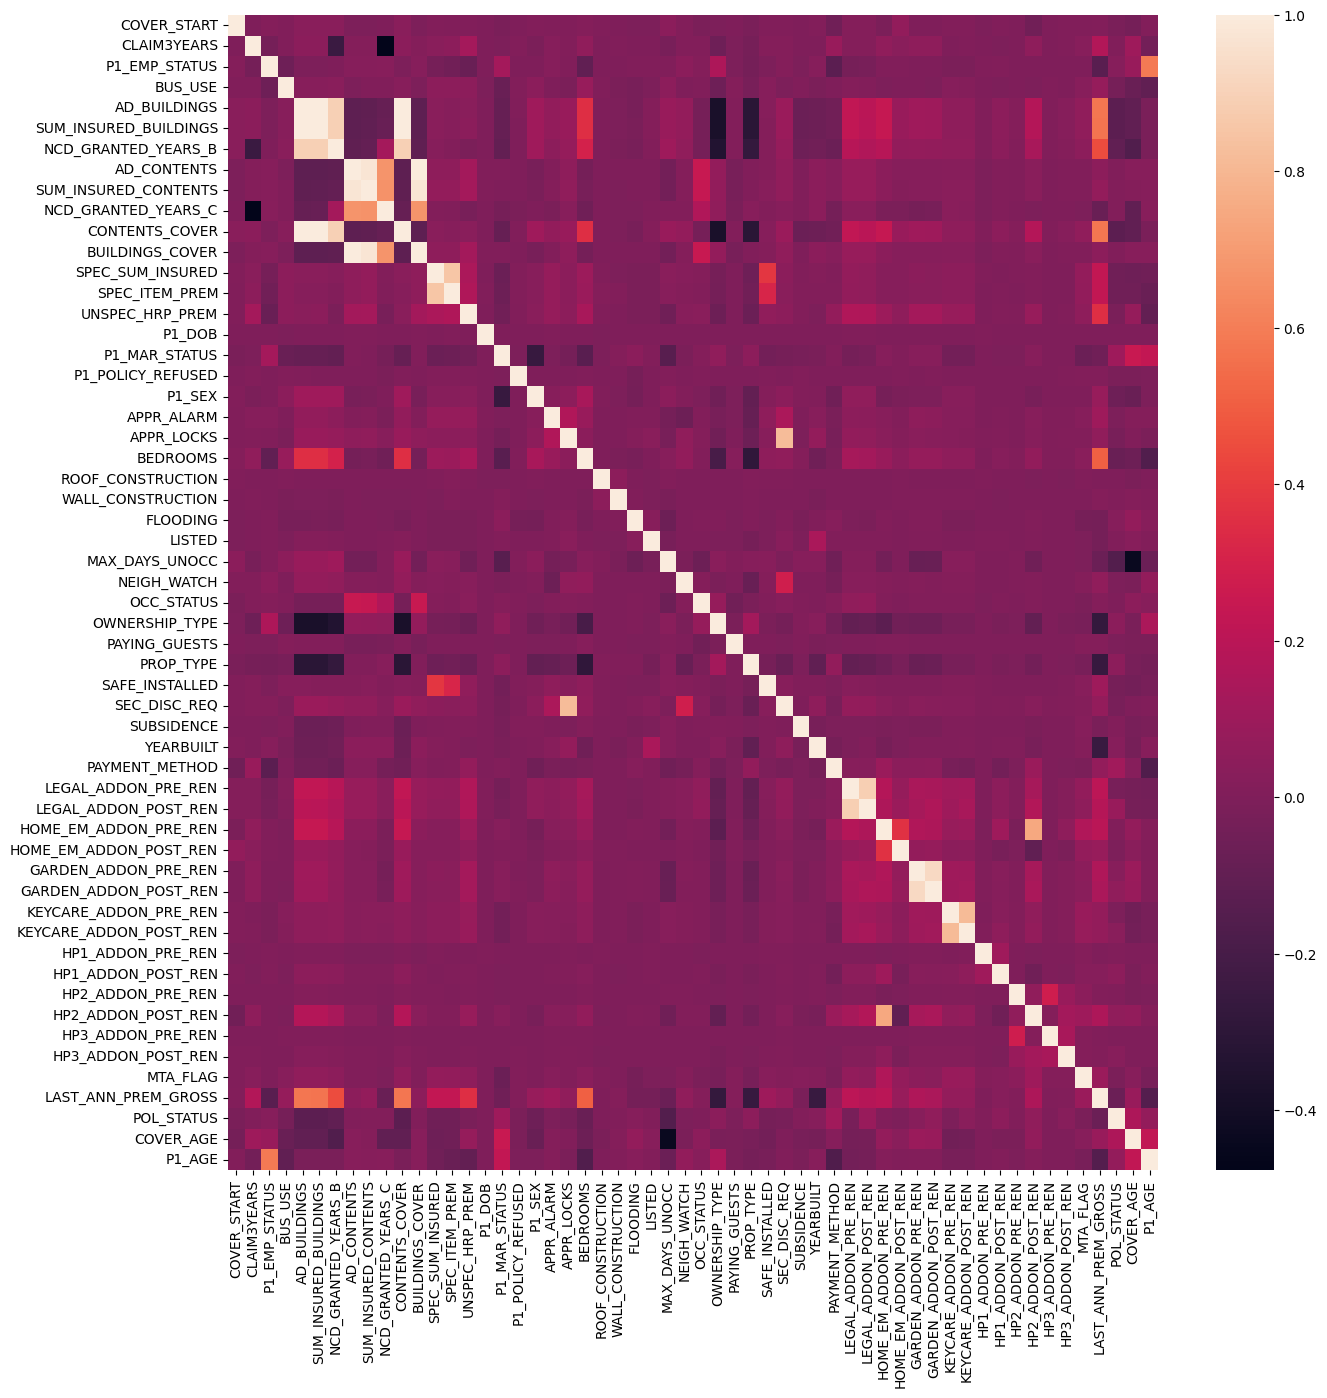

In [76]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(hi_df_cat.corr(), ax=ax)
plt.show()

In [77]:
hi_df_cat.corr()

,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,BUS_USE,AD_BUILDINGS,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,AD_CONTENTS,SUM_INSURED_CONTENTS,NCD_GRANTED_YEARS_C,...,HP1_ADDON_POST_REN,HP2_ADDON_PRE_REN,HP2_ADDON_POST_REN,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,LAST_ANN_PREM_GROSS,POL_STATUS,COVER_AGE,P1_AGE
COVER_START,1.000000,-0.002741,0.014033,0.003796,0.032964,0.032785,0.034925,-0.005476,-0.004235,0.001136,...,0.002855,-0.001366,-0.044306,-0.000071,0.005054,0.007574,0.012110,-0.019835,-0.032633,0.013761
CLAIM3YEARS,-0.002741,1.000000,-0.037735,0.004931,0.040176,0.040248,-0.249231,0.016464,0.017245,-0.476339,...,-0.004412,0.000367,0.050539,0.000273,0.004805,0.029266,0.172696,0.007691,0.104083,-0.041770
P1_EMP_STATUS,0.014033,-0.037735,1.000000,-0.059446,-0.005032,-0.005011,0.001432,0.024488,0.022270,0.030432,...,0.011359,0.000049,-0.000661,0.001540,0.001012,-0.002516,-0.130794,0.019720,0.084313,0.589083
BUS_USE,0.003796,0.004931,-0.059446,1.000000,0.028777,0.028604,0.031472,-0.003805,0.003435,0.006318,...,-0.004977,0.000935,-0.004187,0.003487,0.000185,0.029521,0.073663,-0.028936,-0.073442,-0.106493
AD_BUILDINGS,0.032964,0.040176,-0.005032,0.028777,1.000000,0.997303,0.890458,-0.116050,-0.111120,-0.086770,...,0.045145,0.015081,0.179438,0.004900,0.020044,0.056574,0.575938,-0.122911,-0.106085,-0.018481
SUM_INSURED_BUILDINGS,0.032785,0.040248,-0.005011,0.028604,0.997303,1.000000,0.892838,-0.115568,-0.101956,-0.079751,...,0.045334,0.014751,0.179916,0.004913,0.020143,0.055945,0.573242,-0.119753,-0.104903,-0.018273
NCD_GRANTED_YEARS_B,0.034925,-0.249231,0.001432,0.031472,0.890458,0.892838,1.000000,-0.108671,-0.095201,0.128586,...,0.042276,0.012444,0.140667,0.004804,0.015349,0.044789,0.446783,-0.106020,-0.163178,-0.015591
AD_CONTENTS,-0.005476,0.016464,0.024488,-0.003805,-0.116050,-0.115568,-0.108671,1.000000,0.973645,0.673990,...,0.011042,0.004978,0.034541,-0.000759,0.005923,0.003384,0.048177,0.007752,0.025685,0.027356
SUM_INSURED_CONTENTS,-0.004235,0.017245,0.022270,0.003435,-0.111120,-0.101956,-0.095201,0.973645,1.000000,0.670674,...,0.011177,0.003700,0.034984,0.001591,0.006405,0.005868,0.065879,0.008388,0.019249,0.022963
NCD_GRANTED_YEARS_C,0.001136,-0.476339,0.030432,0.006318,-0.086770,-0.079751,0.128586,0.673990,0.670674,1.000000,...,0.010577,-0.000307,-0.008716,0.001308,0.002262,-0.005638,-0.076433,0.008393,-0.105730,0.030500


Highlight all correlations above 0.8 (including anti-correlations).

In [78]:
# Find columns/rows with occurrences of high correlation
corr_df = feature_filtering(hi_df_cat, threshold=0.8)
corr_df

,AD_BUILDINGS,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B,AD_CONTENTS,SUM_INSURED_CONTENTS,CONTENTS_COVER,BUILDINGS_COVER,SPEC_SUM_INSURED,SPEC_ITEM_PREM,APPR_LOCKS,SEC_DISC_REQ,LEGAL_ADDON_PRE_REN,LEGAL_ADDON_POST_REN,GARDEN_ADDON_PRE_REN,GARDEN_ADDON_POST_REN,KEYCARE_ADDON_PRE_REN,KEYCARE_ADDON_POST_REN
AD_BUILDINGS,0.000000,0.997303,0.890458,0.116050,0.111120,1.000000,0.116050,0.034388,0.023361,0.085674,0.092014,0.223794,0.198747,0.109334,0.102283,0.050989,0.054020
SUM_INSURED_BUILDINGS,0.997303,0.000000,0.892838,0.115568,0.101956,0.997303,0.115568,0.033880,0.023776,0.085789,0.091892,0.223082,0.197898,0.109022,0.101912,0.050629,0.053707
NCD_GRANTED_YEARS_B,0.890458,0.892838,0.000000,0.108671,0.095201,0.890458,0.108671,0.022869,0.010202,0.072856,0.073676,0.189256,0.168201,0.068510,0.063832,0.055680,0.056495
AD_CONTENTS,0.116050,0.115568,0.108671,0.000000,0.973645,0.116050,1.000000,0.053841,0.051219,0.050778,0.054877,0.080618,0.081402,0.020351,0.021853,0.027786,0.029205
SUM_INSURED_CONTENTS,0.111120,0.101956,0.095201,0.973645,0.000000,0.111120,0.973645,0.070470,0.067122,0.054492,0.057381,0.081074,0.080930,0.021406,0.022396,0.032080,0.032584
CONTENTS_COVER,1.000000,0.997303,0.890458,0.116050,0.111120,0.000000,0.116050,0.034388,0.023361,0.085674,0.092014,0.223794,0.198747,0.109334,0.102283,0.050989,0.054020
BUILDINGS_COVER,0.116050,0.115568,0.108671,1.000000,0.973645,0.116050,0.000000,0.053841,0.051219,0.050778,0.054877,0.080618,0.081402,0.020351,0.021853,0.027786,0.029205
SPEC_SUM_INSURED,0.034388,0.033880,0.022869,0.053841,0.070470,0.034388,0.053841,0.000000,0.851473,0.039925,0.039427,0.067553,0.057829,0.037130,0.034193,0.045202,0.043840
SPEC_ITEM_PREM,0.023361,0.023776,0.010202,0.051219,0.067122,0.023361,0.051219,0.851473,0.000000,0.037360,0.035944,0.062960,0.057586,0.036377,0.035556,0.045089,0.045498
APPR_LOCKS,0.085674,0.085789,0.072856,0.050778,0.054492,0.085674,0.050778,0.039925,0.037360,0.000000,0.819286,0.060002,0.055485,0.032911,0.030414,0.020203,0.019196


Remove highly correlated features but keep the 'CONTENTS_COVER' columns

In [79]:
corr_df.loc[:,(corr_df['CONTENTS_COVER'] > 0.8)]

,AD_BUILDINGS,SUM_INSURED_BUILDINGS,NCD_GRANTED_YEARS_B
AD_BUILDINGS,0.000000,0.997303,0.890458
SUM_INSURED_BUILDINGS,0.997303,0.000000,0.892838
NCD_GRANTED_YEARS_B,0.890458,0.892838,0.000000
AD_CONTENTS,0.116050,0.115568,0.108671
SUM_INSURED_CONTENTS,0.111120,0.101956,0.095201
CONTENTS_COVER,1.000000,0.997303,0.890458
BUILDINGS_COVER,0.116050,0.115568,0.108671
SPEC_SUM_INSURED,0.034388,0.033880,0.022869
SPEC_ITEM_PREM,0.023361,0.023776,0.010202
APPR_LOCKS,0.085674,0.085789,0.072856


In [80]:
columns_to_go = corr_df.loc[:,(corr_df['CONTENTS_COVER'] > 0.8)].index.tolist()

In [81]:
columns_to_go.remove('CONTENTS_COVER')

In [82]:
columns_to_go += ['P1_DOB', 'COVER_START']

In [83]:
columns_to_go

['AD_BUILDINGS',
 'SUM_INSURED_BUILDINGS',
 'NCD_GRANTED_YEARS_B',
 'AD_CONTENTS',
 'SUM_INSURED_CONTENTS',
 'BUILDINGS_COVER',
 'SPEC_SUM_INSURED',
 'SPEC_ITEM_PREM',
 'APPR_LOCKS',
 'SEC_DISC_REQ',
 'LEGAL_ADDON_PRE_REN',
 'LEGAL_ADDON_POST_REN',
 'GARDEN_ADDON_PRE_REN',
 'GARDEN_ADDON_POST_REN',
 'KEYCARE_ADDON_PRE_REN',
 'KEYCARE_ADDON_POST_REN',
 'P1_DOB',
 'COVER_START']

In [84]:
hi_df_cat_2 = hi_df_cat.drop(columns_to_go, axis=1)
hi_df_cat_2

,CLAIM3YEARS,P1_EMP_STATUS,BUS_USE,NCD_GRANTED_YEARS_C,CONTENTS_COVER,UNSPEC_HRP_PREM,P1_MAR_STATUS,P1_POLICY_REFUSED,P1_SEX,APPR_ALARM,...,HP1_ADDON_POST_REN,HP2_ADDON_PRE_REN,HP2_ADDON_POST_REN,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,LAST_ANN_PREM_GROSS,POL_STATUS,COVER_AGE,P1_AGE
0,0,7,0,7.0,1,12.45,6,0,1,0,...,0,0,0,0,0,0,274.81,0,5,73
1,0,2,1,7.0,1,24.60,4,0,1,0,...,0,0,0,0,0,1,308.83,1,5,42
2,0,2,0,7.0,0,0.00,8,0,1,1,...,0,0,0,0,0,1,52.65,1,5,65
3,0,7,0,7.0,0,0.00,9,0,0,0,...,0,0,0,0,0,0,54.23,1,5,87
4,0,7,0,7.0,1,19.82,4,0,1,1,...,0,0,0,0,0,0,244.58,1,5,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256131,1,7,0,2.0,1,19.06,6,0,0,0,...,0,0,0,0,0,0,235.08,0,7,75
256132,0,7,0,5.0,1,26.79,4,0,1,0,...,0,0,0,0,0,1,194.02,1,12,84
256133,0,7,0,5.0,1,0.00,6,0,1,1,...,0,0,0,0,0,0,287.30,1,6,67
256134,0,7,0,0.0,1,0.00,6,0,1,0,...,0,0,0,0,0,0,457.57,0,8,75


In [85]:
# hi_df_cat_2.to_pickle('./data/hi_df_cat_2.pkl')

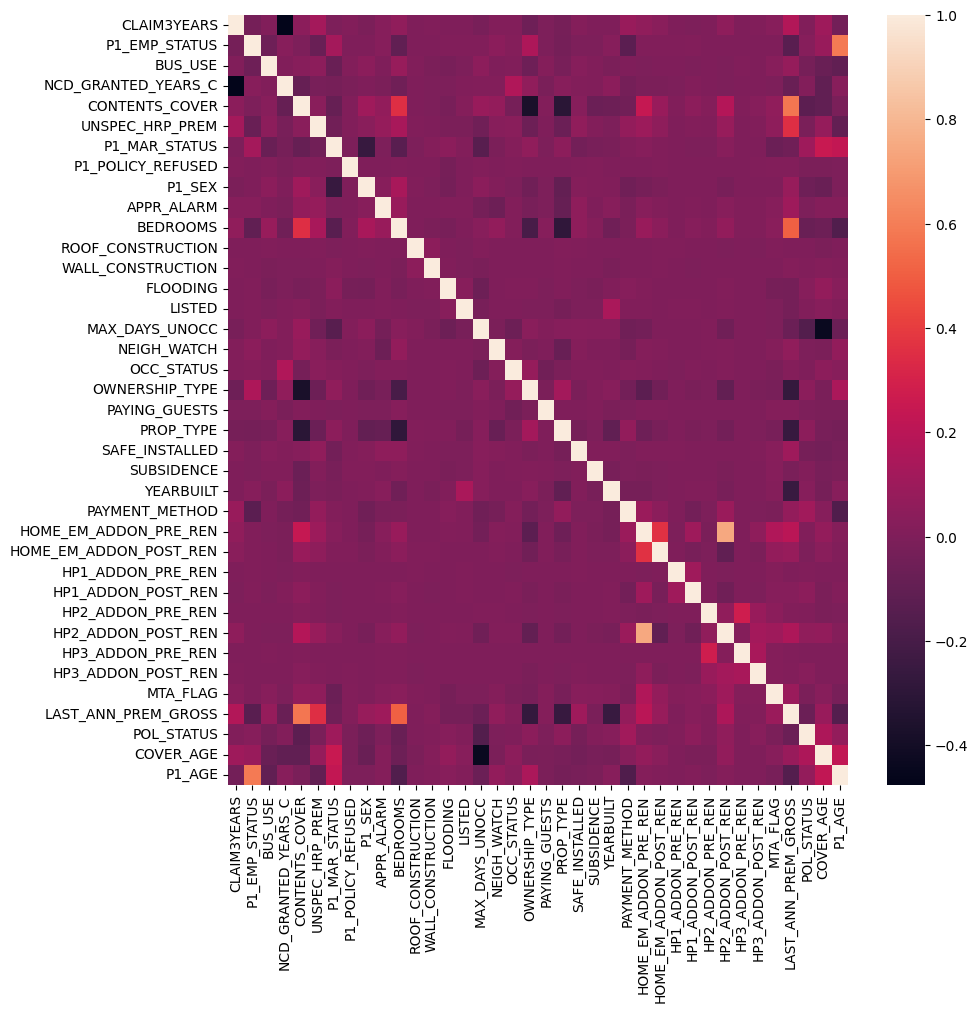

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(hi_df_cat_2.corr(), ax=ax)
plt.show()

In [87]:
list(hi_df_cat_2.columns), len(list(hi_df_cat_2.columns))

(['CLAIM3YEARS',
  'P1_EMP_STATUS',
  'BUS_USE',
  'NCD_GRANTED_YEARS_C',
  'CONTENTS_COVER',
  'UNSPEC_HRP_PREM',
  'P1_MAR_STATUS',
  'P1_POLICY_REFUSED',
  'P1_SEX',
  'APPR_ALARM',
  'BEDROOMS',
  'ROOF_CONSTRUCTION',
  'WALL_CONSTRUCTION',
  'FLOODING',
  'LISTED',
  'MAX_DAYS_UNOCC',
  'NEIGH_WATCH',
  'OCC_STATUS',
  'OWNERSHIP_TYPE',
  'PAYING_GUESTS',
  'PROP_TYPE',
  'SAFE_INSTALLED',
  'SUBSIDENCE',
  'YEARBUILT',
  'PAYMENT_METHOD',
  'HOME_EM_ADDON_PRE_REN',
  'HOME_EM_ADDON_POST_REN',
  'HP1_ADDON_PRE_REN',
  'HP1_ADDON_POST_REN',
  'HP2_ADDON_PRE_REN',
  'HP2_ADDON_POST_REN',
  'HP3_ADDON_PRE_REN',
  'HP3_ADDON_POST_REN',
  'MTA_FLAG',
  'LAST_ANN_PREM_GROSS',
  'POL_STATUS',
  'COVER_AGE',
  'P1_AGE'],
 38)

### Feature Selection

In [24]:
features = list(hi_df_cat_2.columns)
features.remove('POL_STATUS')

targets = ['POL_STATUS']

features, targets

(['CLAIM3YEARS',
  'P1_EMP_STATUS',
  'BUS_USE',
  'NCD_GRANTED_YEARS_C',
  'CONTENTS_COVER',
  'UNSPEC_HRP_PREM',
  'P1_MAR_STATUS',
  'P1_POLICY_REFUSED',
  'P1_SEX',
  'APPR_ALARM',
  'BEDROOMS',
  'ROOF_CONSTRUCTION',
  'WALL_CONSTRUCTION',
  'FLOODING',
  'LISTED',
  'MAX_DAYS_UNOCC',
  'NEIGH_WATCH',
  'OCC_STATUS',
  'OWNERSHIP_TYPE',
  'PAYING_GUESTS',
  'PROP_TYPE',
  'SAFE_INSTALLED',
  'SUBSIDENCE',
  'YEARBUILT',
  'PAYMENT_METHOD',
  'HOME_EM_ADDON_PRE_REN',
  'HOME_EM_ADDON_POST_REN',
  'HP1_ADDON_PRE_REN',
  'HP1_ADDON_POST_REN',
  'HP2_ADDON_PRE_REN',
  'HP2_ADDON_POST_REN',
  'HP3_ADDON_PRE_REN',
  'HP3_ADDON_POST_REN',
  'MTA_FLAG',
  'LAST_ANN_PREM_GROSS',
  'COVER_AGE',
  'P1_AGE'],
 ['POL_STATUS'])

In [25]:
# Load and split data
x_data, y_data = select_features(hi_df_cat_2, feature_cols=features, target_cols=targets)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

Create a PCA train/test data set, for later:

In [26]:
X_train_pca, X_test_pca, _, X_train_pca_df = apply_pca(X_train, X_test=X_test, n_components=0.975)

Number of principal components: 4
PCA model and DataFrame saved.


## Modeling

### XGBoost

In [45]:
# x_data, y_data = select_features(hi_df_cat_2, feature_cols=features, target_cols=targets)
# X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [46]:
# Re-weighting
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
scale_pos_weight[0]

0.4310971454531688

In [47]:
# Init classifier
xgb_cl = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight[0], random_state=42)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
y_preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, y_preds)

0.6622047035792704

In [48]:
conf_mat = confusion_matrix(y_test, y_preds)
conf_mat

array([[ 7443,  3854],
       [ 8915, 17589]])

In [49]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.46      0.66      0.54     11297
           1       0.82      0.66      0.73     26504

    accuracy                           0.66     37801
   macro avg       0.64      0.66      0.64     37801
weighted avg       0.71      0.66      0.68     37801



### Try XGBoost with PCA

In [50]:
# Init classifier
xgb_cl_pca = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight[0], random_state=42)

# Fit
xgb_cl_pca.fit(X_train_pca, y_train)

# Predict
y_preds_pca = xgb_cl_pca.predict(X_test_pca)

# Score
accuracy_score(y_test, y_preds_pca)

0.6058834422369779

In [52]:
conf_mat = confusion_matrix(y_test, y_preds_pca)
conf_mat

array([[ 6411,  4886],
       [10012, 16492]])

In [53]:
print(classification_report(y_test, y_preds_pca))

              precision    recall  f1-score   support

           0       0.39      0.57      0.46     11297
           1       0.77      0.62      0.69     26504

    accuracy                           0.61     37801
   macro avg       0.58      0.59      0.58     37801
weighted avg       0.66      0.61      0.62     37801



### Random Forest Classification

In [54]:
# x_data, y_data = select_features(hi_df_cat_2, feature_cols=features, target_cols=targets)
# X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [55]:
clf=RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight='balanced', random_state=42)

In [56]:
y_pred = clf.predict(X_test)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9999735456733949
0.7153249914023438


In [57]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.25      0.34     11297
           1       0.74      0.91      0.82     26504

    accuracy                           0.72     37801
   macro avg       0.65      0.58      0.58     37801
weighted avg       0.68      0.72      0.68     37801



In [58]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[ 2827,  8470],
       [ 2291, 24213]])

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
tp/(tp+fp), tp/(tp +fn)

2827 8470 2291 24213


(0.7408438637823945, 0.9135602173256867)

## Random Forest Classifier with PCA

In [60]:
# x_data, y_data = select_features(hi_df_cat_2, feature_cols=features, target_cols=targets)
# X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

# X_train_pca, X_test_pca, _, X_train_pca_df = apply_pca(X_train, X_test=X_test, n_components=0.98)
# x_data

In [61]:
clf_pca=RandomForestClassifier(class_weight='balanced', random_state=42)
clf_pca.fit(X_train_pca, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(class_weight='balanced', random_state=42)

In [62]:
y_pred = clf_pca.predict(X_test_pca)

print(clf_pca.score(X_train_pca, y_train))
print(clf_pca.score(X_test_pca, y_test))

0.9999603185100924
0.6780772995423402


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.19      0.26     11297
           1       0.72      0.89      0.79     26504

    accuracy                           0.68     37801
   macro avg       0.57      0.54      0.53     37801
weighted avg       0.63      0.68      0.63     37801



### Randomised Grid Search with Random Forest Classifier

In [64]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=25, cv=5, verbose=3, random_state=42, n_jobs=-1, scoring=make_scorer(f1_score))

# Fit the model
random_search.fit(X_train_pca, y_train.ravel())

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

# Use the best estimator to make predictions
best_clf = random_search.best_estimator_
y_pred_pca_best = best_clf.predict(X_test_pca)

# Evaluate the model
print(classification_report(y_test, y_pred_pca_best))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 2/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=558;, score=0.697 total time= 4.9min
[CV 1/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=558;, score=0.694 total time= 4.9min
[CV 3/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=558;, score=0.686 total time= 4.9min
[CV 4/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=558;, score=0.704 total time=19.6min
[CV 5/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=558;, score=0.697 total time=19.6min
[CV 1/5] END bootstrap=False, max_depth=4, min_samples_leaf=8, min_samples_split=4, n_estimators=761;, score=0.687 total time=21.0min
[CV 2/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=800;, score=0.715 total time=26

In [ ]:
# Load/Save the best model
# best_model_pca = random_search.best_estimator_
# joblib.dump(best_model_pca, './models/best_model_pca.pkl')
best_model_pca = joblib.load('./models/best_model_pca.pkl')

In [76]:
param_dist_non_pca = {
    'n_estimators': randint(500, 1000),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
clf_non_pca = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the RandomizedSearchCV object
random_search_non_pca = RandomizedSearchCV(clf_non_pca, param_distributions=param_dist_non_pca, n_iter=25, cv=5, verbose=3, random_state=42, n_jobs=-1, scoring=make_scorer(f1_score))

# Fit the model
random_search_non_pca.fit(X_train, y_train.ravel())

# Print the best parameters and best score
print("Best parameters found: ", random_search_non_pca.best_params_)
print("Best score: ", random_search_non_pca.best_score_)

# Use the best estimator to make predictions
best_clf_non_pca = random_search_non_pca.best_estimator_
y_pred_best = best_clf_non_pca.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=958;, score=0.676 total time= 4.0min
[CV 3/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=958;, score=0.675 total time= 4.0min
[CV 2/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=958;, score=0.677 total time= 4.0min
[CV 1/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.726 total time= 4.4min
[CV 2/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.723 total time= 4.4min
[CV 3/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.725 total time= 4.4min
[CV 5/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.728 total time= 

In [ ]:
# Load/Save the best model
# best_model = random_search_non_pca.best_estimator_
# joblib.dump(best_model, './models/best_model.pkl')
best_model = joblib.load('./models/best_model.pkl')

## Feature Importance

### Random Forest Classifier Feature Importance

In [29]:
# Train a RandomForestClassifier
model = best_model #RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train.ravel())

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                   Feature    Importance
34     LAST_ANN_PREM_GROSS  1.328575e-01
6            P1_MAR_STATUS  1.193294e-01
35               COVER_AGE  1.149192e-01
24          PAYMENT_METHOD  9.022230e-02
36                  P1_AGE  8.407783e-02
15          MAX_DAYS_UNOCC  7.541750e-02
5          UNSPEC_HRP_PREM  4.226507e-02
3      NCD_GRANTED_YEARS_C  4.105196e-02
20               PROP_TYPE  4.008502e-02
4           CONTENTS_COVER  3.997957e-02
23               YEARBUILT  3.778886e-02
30      HP2_ADDON_POST_REN  2.910314e-02
10                BEDROOMS  2.293069e-02
33                MTA_FLAG  2.145423e-02
28      HP1_ADDON_POST_REN  1.623605e-02
25   HOME_EM_ADDON_PRE_REN  1.581294e-02
18          OWNERSHIP_TYPE  1.558923e-02
8                   P1_SEX  1.390553e-02
1            P1_EMP_STATUS  1.102695e-02
16             NEIGH_WATCH  9.951970e-03
26  HOME_EM_ADDON_POST_REN  7.360035e-03
0              CLAIM3YEARS  6.676579e-03
9               APPR_ALARM  4.132332e-03
32      HP3_ADDO

In [ ]:
i = 0
accumulated = 0
for k,v, in feature_importances.to_dict(orient='index').items():
    accumulated += v['Importance']
    print(f"{v['Feature']} : {accumulated}")


LAST_ANN_PREM_GROSS : 0.13285754059341306
P1_MAR_STATUS : 0.2521869096373443
COVER_AGE : 0.3671060636823234
PAYMENT_METHOD : 0.45732835964237106
P1_AGE : 0.5414061945657228
MAX_DAYS_UNOCC : 0.6168236945073386
UNSPEC_HRP_PREM : 0.6590887682315413
NCD_GRANTED_YEARS_C : 0.7001407274201976
PROP_TYPE : 0.740225752162763
CONTENTS_COVER : 0.7802053236518705
YEARBUILT : 0.8179941838797269
HP2_ADDON_POST_REN : 0.8470973256386904
BEDROOMS : 0.8700280139752757
MTA_FLAG : 0.8914822480467146
HP1_ADDON_POST_REN : 0.9077182996481249
HOME_EM_ADDON_PRE_REN : 0.923531238096736
OWNERSHIP_TYPE : 0.9391204703851758
P1_SEX : 0.9530260026784552
P1_EMP_STATUS : 0.9640529545148636
NEIGH_WATCH : 0.974004924605503
HOME_EM_ADDON_POST_REN : 0.9813649596523101
CLAIM3YEARS : 0.9880415382829498
APPR_ALARM : 0.9921738702068216
HP3_ADDON_POST_REN : 0.9947322063818962
FLOODING : 0.9960550872957307
OCC_STATUS : 0.9972022738306432
BUS_USE : 0.9980927920060949
SUBSIDENCE : 0.9988150314795666
SAFE_INSTALLED : 0.999311965222

We can use the obtained info to train a similar model on a limited set of features. For instance, by setting a threshold of 95% of accumulated importance. This give us the following features:

In [35]:
i = 0
accumulated = 0
sub_features = []
for k,v, in feature_importances.to_dict(orient='index').items():
    accumulated += v['Importance']
    print(f"{v['Feature']} : {accumulated}")
    if accumulated < 0.95:
        sub_features.append(v['Feature'])
    else:
        break

sub_features

LAST_ANN_PREM_GROSS : 0.13285754059341306
P1_MAR_STATUS : 0.2521869096373443
COVER_AGE : 0.3671060636823234
PAYMENT_METHOD : 0.45732835964237106
P1_AGE : 0.5414061945657228
MAX_DAYS_UNOCC : 0.6168236945073386
UNSPEC_HRP_PREM : 0.6590887682315413
NCD_GRANTED_YEARS_C : 0.7001407274201976
PROP_TYPE : 0.740225752162763
CONTENTS_COVER : 0.7802053236518705
YEARBUILT : 0.8179941838797269
HP2_ADDON_POST_REN : 0.8470973256386904
BEDROOMS : 0.8700280139752757
MTA_FLAG : 0.8914822480467146
HP1_ADDON_POST_REN : 0.9077182996481249
HOME_EM_ADDON_PRE_REN : 0.923531238096736
OWNERSHIP_TYPE : 0.9391204703851758
P1_SEX : 0.9530260026784552


['LAST_ANN_PREM_GROSS',
 'P1_MAR_STATUS',
 'COVER_AGE',
 'PAYMENT_METHOD',
 'P1_AGE',
 'MAX_DAYS_UNOCC',
 'UNSPEC_HRP_PREM',
 'NCD_GRANTED_YEARS_C',
 'PROP_TYPE',
 'CONTENTS_COVER',
 'YEARBUILT',
 'HP2_ADDON_POST_REN',
 'BEDROOMS',
 'MTA_FLAG',
 'HP1_ADDON_POST_REN',
 'HOME_EM_ADDON_PRE_REN',
 'OWNERSHIP_TYPE']

### Modelling: revisited

In [36]:
x_data_sub, y_data_sub = select_features(hi_df_cat_2, feature_cols=sub_features, target_cols=targets)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(x_data_sub, y_data_sub, test_size=0.2)

In [37]:
clf_sub=RandomForestClassifier(class_weight='balanced', random_state=42)
clf_sub.fit(X_train_sub, y_train_sub)

y_pred_sub = clf_sub.predict(X_test_sub)
print(classification_report(y_test_sub, y_pred_sub))

conf_mat = confusion_matrix(y_test_sub, y_pred_sub)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       0.51      0.25      0.34     11283
           1       0.74      0.90      0.81     26518

    accuracy                           0.70     37801
   macro avg       0.62      0.57      0.57     37801
weighted avg       0.67      0.70      0.67     37801



In [38]:
conf_mat

array([[ 2844,  8439],
       [ 2724, 23794]])

In [39]:
param_dist_sub = {
    'n_estimators': randint(500, 1000),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
clf_sub_rnd = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create the RandomizedSearchCV object
random_search_sub = RandomizedSearchCV(clf_sub_rnd, param_distributions=param_dist_sub, n_iter=25, cv=5, verbose=3, random_state=42, n_jobs=-1, scoring=make_scorer(f1_score))

# Fit the model
random_search_sub.fit(X_train_sub, y_train_sub.ravel())

# Print the best parameters and best score
print("Best parameters found: ", random_search_sub.best_params_)
print("Best score: ", random_search_sub.best_score_)

# Use the best estimator to make predictions
best_clf_sub = random_search_sub.best_estimator_
y_pred_sub_best = best_clf_sub.predict(X_test_sub)

# Evaluate the model
print(classification_report(y_test_sub, y_pred_sub_best))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=958;, score=0.675 total time= 3.8min
[CV 2/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=958;, score=0.685 total time= 3.9min
[CV 3/5] END bootstrap=True, max_depth=7, min_samples_leaf=19, min_samples_split=12, n_estimators=958;, score=0.680 total time= 3.9min
[CV 2/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.738 total time= 4.2min
[CV 1/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.730 total time= 4.2min
[CV 4/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.731 total time= 4.2min
[CV 5/5] END bootstrap=True, max_depth=15, min_samples_leaf=11, min_samples_split=9, n_estimators=688;, score=0.734 total time= 

In [ ]:
# Load/Save the best model
best_sub_model = random_search_sub.best_estimator_
joblib.dump(best_sub_model, './models/best_sub_model.pkl')
# best_sub_model = joblib.load('./models/best_model.pkl')

['best_sub_model.pkl']

In [61]:
# Train a RandomForestClassifier
model = best_sub_model #RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train.ravel())

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': sub_features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                  Feature  Importance
0     LAST_ANN_PREM_GROSS    0.163302
2               COVER_AGE    0.115813
1           P1_MAR_STATUS    0.114091
4                  P1_AGE    0.103843
3          PAYMENT_METHOD    0.082564
5          MAX_DAYS_UNOCC    0.072694
6         UNSPEC_HRP_PREM    0.049743
8               PROP_TYPE    0.047788
7     NCD_GRANTED_YEARS_C    0.046111
10              YEARBUILT    0.044146
9          CONTENTS_COVER    0.034536
11     HP2_ADDON_POST_REN    0.026286
12               BEDROOMS    0.025166
13               MTA_FLAG    0.024112
16         OWNERSHIP_TYPE    0.017503
15  HOME_EM_ADDON_PRE_REN    0.016958
14     HP1_ADDON_POST_REN    0.015344


In [62]:
i = 0
accumulated = 0
sub_sub_features = []
for k,v, in feature_importances.to_dict(orient='index').items():
    accumulated += v['Importance']
    print(f"{v['Feature']} : {accumulated}")
    if accumulated < 0.95:
        sub_sub_features.append(v['Feature'])
    else:
        break

sub_sub_features

LAST_ANN_PREM_GROSS : 0.163301568635052
COVER_AGE : 0.27911497230420806
P1_MAR_STATUS : 0.3932059346304074
P1_AGE : 0.49704928813953736
PAYMENT_METHOD : 0.579613003184869
MAX_DAYS_UNOCC : 0.652307294633428
UNSPEC_HRP_PREM : 0.7020499294341618
PROP_TYPE : 0.7498376660930989
NCD_GRANTED_YEARS_C : 0.795949112026391
YEARBUILT : 0.840094741510429
CONTENTS_COVER : 0.8746304356983796
HP2_ADDON_POST_REN : 0.9009161385284092
BEDROOMS : 0.9260820024857017
MTA_FLAG : 0.9501940198645201


['LAST_ANN_PREM_GROSS',
 'COVER_AGE',
 'P1_MAR_STATUS',
 'P1_AGE',
 'PAYMENT_METHOD',
 'MAX_DAYS_UNOCC',
 'UNSPEC_HRP_PREM',
 'PROP_TYPE',
 'NCD_GRANTED_YEARS_C',
 'YEARBUILT',
 'CONTENTS_COVER',
 'HP2_ADDON_POST_REN',
 'BEDROOMS']

# Final Remarks and Conclusion

I have conducted an analysis of the home insurance data. Some additional data that could have been useful:  
- Credit rating
- end date of policy
  
Furthermore:
- The data is quite rich in features, but approx. 1/3 is made redundant by simple data cleansing and feature selection based on correlations 
- It should be mentioned, that the correlation analysis could/should be more detailed, using additional/different correlation approaches, in a real-world scenario.
- Tried to model the retention based on the features:
  - Can reach precision of  approx. 74% by using sklearn Random Forest Classifier as it is on par with XGBoost (did not do grid search for XGBoost)




There are more investigations one could consider:
- Use Logistic regression (tried, but wasn't musch different (or better - did not try grid search, though))
- Use other ML approach (SVM, neural net, ...)

It should be pointed out that
- A random forest-based approach is well suited to this type of mixed data
- HOWEVER, whereas a random forests-based model may perform well on the type of data it has been trained on, it may struggle with data it has not been exposed to. In other words, random forest do not generalise well to new/hitherto unseen data   